# Redo the spatial resolved grain maps of PARADIM-2 in the focus beam

In [1]:
%run -i ../tomography/utils.py

In [2]:
%run -i startup3.py

## Extract the peak positions

### Load and reformat the data

`db_raw` is the databroker database.

In [3]:
sel_row = df_uid.loc[0]
sel_row

uid       4714edaf-227b-4caa-a53b-bc8bf110f7e5
sample                               PARAMID-2
task               a coarse grid rocking curve
beam                                     focus
Name: 0, dtype: object

In [4]:
run = db_raw[sel_row['uid']]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [5]:
data

<xarray.Dataset>
Dimensions:               (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 4887)
Coordinates:
  * frame                 (frame) int64 0 1 2 3 4 5 ... 4882 4883 4884 4885 4886
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image          (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mXBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mXBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [6]:
del sel_row

### Load the light and dark frame

In [7]:
shadows = xr.load_dataarray("/Volumes/STAO_EXT/test_filtered_frames_array.nc")

In [8]:
subtracted = (shadows[1] - shadows[0]).astype(np.int16)

### Select the ones to track

We select the 20 largest peaks to track.

In [9]:
peaks = db_csv.get_data("60c140527b072673151c761e")
peaks = peaks.sort_values("mass", ascending=False).iloc[:20]
windows = create_windows_from_width(peaks, 50)

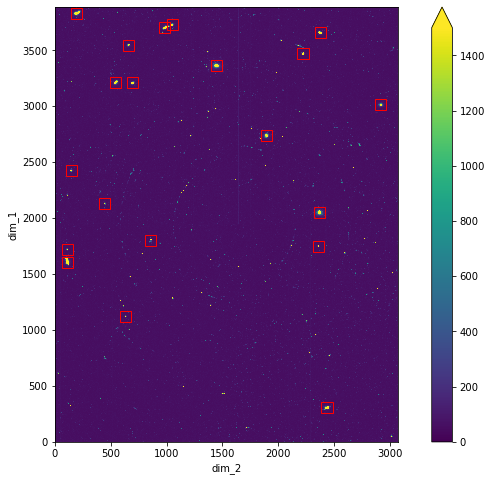

In [10]:
facet = subtracted.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)
plt.show()

In [11]:
del facet

### Run the tracking

In [12]:
grains = create_grain_maps(image_data, windows, run.start)

In [13]:
db_cdf.insert(grains, dict(**run.start, tag="grain maps"))

'60d4dad53652b26d789f32df'

In [14]:
del grains

### Visualize the grain maps

This is the final result of 20 grain maps. They are visualized in a log scale color map.

In [3]:
grains = db_cdf.get_data("60d4dad53652b26d789f32df")
grains = grains.set_index({"grain": ["x", "y"]})
grains

<xarray.Dataset>
Dimensions:  (dim_0: 181, dim_1: 27, grain: 20)
Coordinates:
  * dim_0    (dim_0) float64 0.0 0.25 0.5 0.75 1.0 ... 44.25 44.5 44.75 45.0
  * dim_1    (dim_1) float64 6.5 6.25 6.0 5.75 5.5 ... 1.0 0.75 0.5 0.25 0.0
  * grain    (grain) MultiIndex
  - x        (grain) int64 195 1447 986 115 548 2435 ... 449 113 2358 861 634
  - y        (grain) int64 3832 3363 3703 1607 3214 ... 2131 1721 1750 1803 1122
Data variables:
    maps     (dim_0, dim_1, grain) float64 503.5 525.7 498.2 ... 464.5 502.6
    dx       (grain) int32 50 50 50 50 50 50 50 50 ... 50 50 50 50 50 50 50 50
    dy       (grain) int32 50 50 50 50 50 50 50 50 ... 50 50 50 50 50 50 50 50

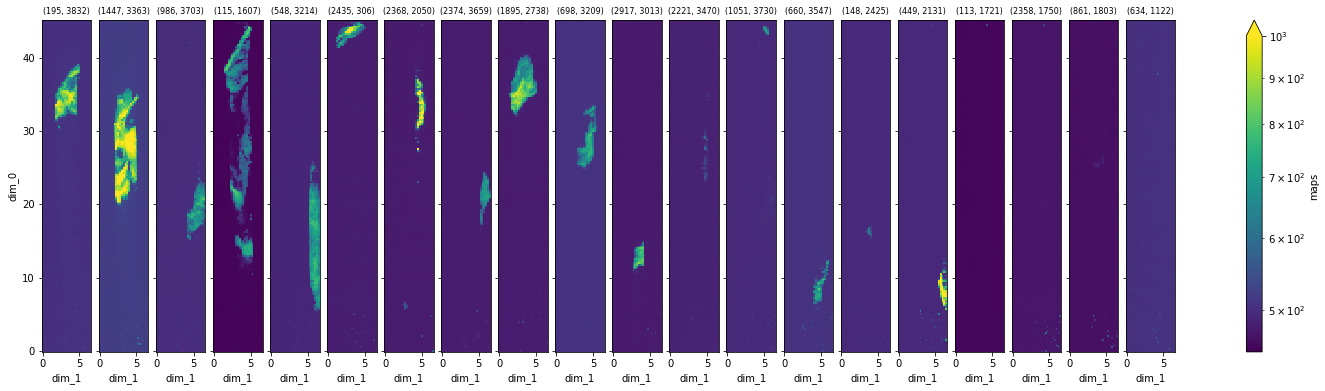

In [4]:
facet = plot_grain_maps(grains, norm=mpl.colors.LogNorm(vmin=450, vmax=1000))
facet.set_titles(template="{value}", size=8)
del facet

### Compare it with the one from the slit beam

In [5]:
grains2 = db_cdf.get_data("60ca20090ea9000d07b715ff")
grains2 = grains2.set_index({"grain": ["x", "y"]})
grains2

<xarray.Dataset>
Dimensions:  (dim_0: 181, dim_1: 27, grain: 20)
Coordinates:
  * dim_0    (dim_0) float64 0.0 0.25 0.5 0.75 1.0 ... 44.25 44.5 44.75 45.0
  * dim_1    (dim_1) float64 6.5 6.25 6.0 5.75 5.5 ... 1.0 0.75 0.5 0.25 0.0
  * grain    (grain) MultiIndex
  - x        (grain) int64 195 1447 986 115 548 2435 ... 449 113 2358 861 634
  - y        (grain) int64 3832 3363 3703 1607 3214 ... 2131 1721 1750 1803 1122
Data variables:
    maps     (grain, dim_0, dim_1) float64 503.3 503.8 503.4 ... 507.0 506.2
    dx       (grain) int32 58 48 54 57 46 53 40 39 ... 24 23 20 20 16 16 30 15
    dy       (grain) int32 58 48 54 57 46 53 40 39 ... 24 23 20 20 16 16 30 15

In [6]:
grains["maps"].attrs["standard_name"] = "focus beam"
grains2["maps"].attrs["standard_name"] = "slit beam"

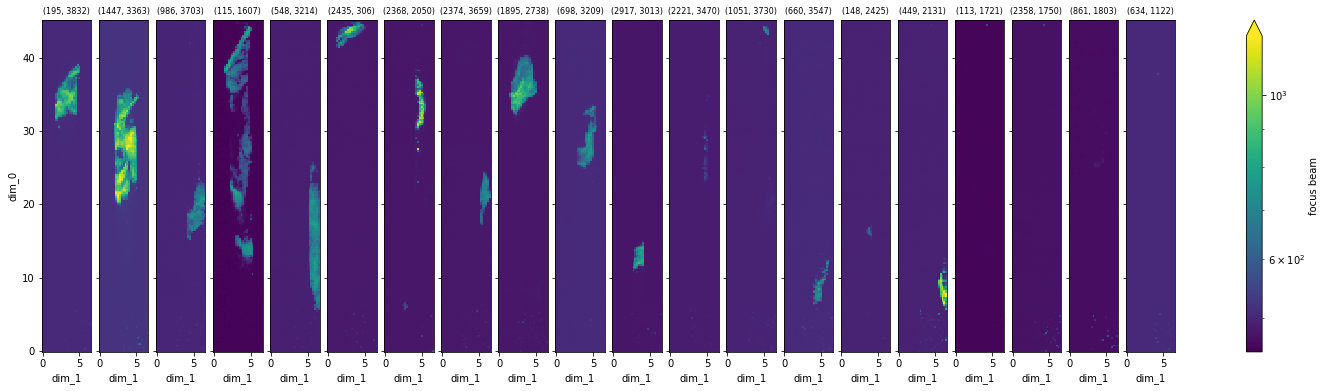

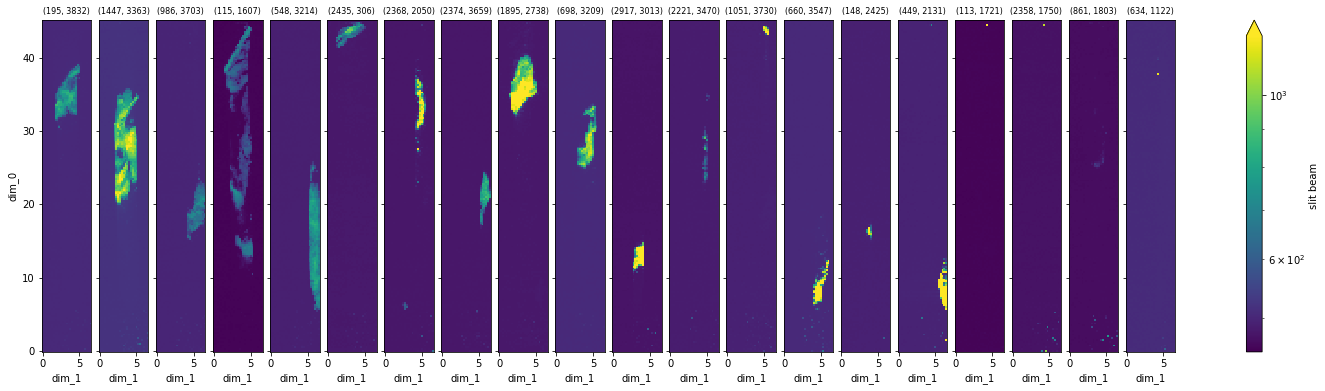

In [7]:
facet = plot_grain_maps(grains, norm=mpl.colors.LogNorm(vmin=450, vmax=1200))
facet.set_titles(template="{value}", size=8)
facet = plot_grain_maps(grains2, norm=mpl.colors.LogNorm(vmin=450, vmax=1200))
facet.set_titles(template="{value}", size=8)
del facet

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [8]:
mean_map = grains["maps"].mean(dim="grain")

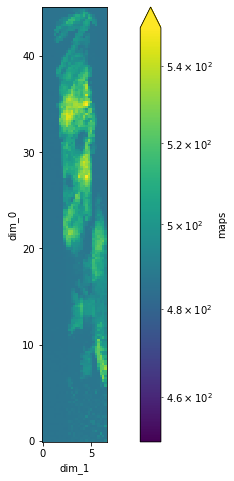

In [9]:
facet = mean_map.plot.pcolormesh(size=8, norm=mpl.colors.LogNorm(vmin=450, vmax=550))
set_real_aspect(facet.axes)